In [1]:
from pyspark.mllib.stat import Statistics
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [2]:
from pyspark.ml.linalg import DenseVector, Vectors
from pyspark.mllib.linalg import Vectors as MLLVectors
from pyspark.ml.feature import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = spark.read.load("credit_feats.parquet")
df.createOrReplaceTempView("credit")

# Correlation analysis

In [4]:
t = df.rdd
t.take(3)

[Row(label=0.0, features=SparseVector(33, {0: 1.0, 4: 1.0, 8: 1.0, 13: 1.0, 14: 1.0, 18: 1.0, 19: 1.0, 21: 1.0, 26: 1.0, 30: 0.7892, 31: -0.2587, 32: -0.248})),
 Row(label=0.0, features=SparseVector(33, {0: 1.0, 5: 1.0, 8: 1.0, 16: 1.0, 21: 1.0, 24: 1.0, 30: -0.9708, 31: -0.2587, 32: -0.248})),
 Row(label=0.0, features=SparseVector(33, {0: 1.0, 5: 1.0, 8: 1.0, 14: 1.0, 16: 1.0, 20: 1.0, 21: 1.0, 24: 1.0, 30: -0.9708, 31: 0.1411, 32: 0.1232}))]

To do : scale the last two arguments. What is the difference between normalization and scaling? Then consider doing PCA to extract features.

In [5]:
t2 = t.map(lambda x: MLLVectors.dense([x[1][ind] for ind in range(33) ]))
t2.take(3)
corr_mat = Statistics.corr(t2)

(-0.66521102813819788, -0.014720820340594031, 0.42858075618167812, 0.16308049822391335)


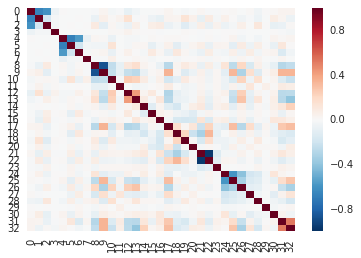

In [6]:
import seaborn as sns
sns.heatmap(corr_mat)
print(corr_mat[0,1], corr_mat[7,8], corr_mat[12,13], corr_mat[17,18])

Only correlation between states is high, but that is probably because of NJ and NY, which have very low numbers.

# PCA

In [7]:
pca = PCA(k=10, inputCol="features", outputCol="pca_features")
model = pca.fit(df)

In [8]:
print(model.explainedVariance)
df2 = model.transform(df)

[0.226756221786,0.132098414649,0.0803752904841,0.0645871202011,0.0586212405539,0.0437725352798,0.0428123200999,0.0410443324169,0.0374258047875,0.0353281563468]


In [9]:
df2.select("label", "pca_features").write.mode('overwrite').save("credit_pca_feats.parquet")